In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [3]:
# plot/colors definitions
cpath = '/n/groups/datta/win/longtogeny/code/notebooks/exploration/Dana'
data_loc=cpath+'/figs/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

sns.set_style('white')
plt.style.use('dark_background')
cmm = sns.color_palette("light:b", as_cmap=True)
cmf = sns.color_palette("light:orange", as_cmap=True)

In [4]:
def compute_usage(df):
    onsets = np.where(np.diff(df['syllables']) != 0)[0]
    usage = df.loc[df.index[onsets], 'syllables'].value_counts(normalize=True)
    return usage

In [5]:
# filter by syllable usage
def syll_index_above_threshold(mean_df, threshold = 0.01):
    syll_mean_usage = mean_df.groupby(['syllables']).mean()
    return syll_mean_usage[syll_mean_usage > threshold].index.to_list()

In [6]:
def KLD_analysis(frequencies):
    '''rows are sessions (or mice/phases), columns are variables (syllables)'''
    cohort_dist=np.zeros((len(frequencies),len(frequencies)),dtype=float)
    x=0
    y=0
    for i in frequencies:
        for j in frequencies:
            i[i==0]=.0000000001
            j[j==0]=.0000000001
            cohort_dist[x,y]=scipy.stats.entropy(pk=np.array(i), qk=np.array(j))
            y=y+1
        y=0
        x=x+1
    #cohort_dist[cohort_dist==0]='nan'
    return cohort_dist

def plot_KLD(cohort_dist,age_labels,vmax=1):
    # cohort_dist is matrix of
    seqmatcolor='Purples_r'
    cmg=sns.clustermap(cohort_dist,cmap=seqmatcolor,xticklabels=1,yticklabels=1,
                   colors_ratio=0.2,cbar_pos=(0.99, 0.045, 0.03, .70),
                   col_cluster=False,row_cluster=False,
                   method='average',metric='sqeuclidean', vmax=vmax)
    cmg.fig.set_size_inches(10,10)
    ax = cmg.ax_heatmap
    ax.set_xticklabels(age_labels)
    ax.set_yticklabels(age_labels)
    ax.set_title('distnace between ontogeny and longtogeny',fontsize=12)
    plt.show()

In [7]:
## upload data frame males
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_02/ontogeny_males.parquet')
df = pd.read_parquet(path)

In [8]:
# change age to weeks
df['age'].replace(['7wks', '3months', '9wks', '12months', '6months', '18months','3wks', '5wks','9months','22months'],
           ['07wks','12wks','09wks','52wks','24wks','78wks','03wks','05wks','36wks','90wks'], inplace=True)

In [9]:
# calculate usage
musages = df.groupby(['age', 'uuid','experiment'], observed=True, sort=False).apply(compute_usage)
musage_mtx = pd.pivot_table(musages.reset_index(), index=['age', 'uuid','experiment'], columns='syllables').fillna(0)
musage_mtx.columns = musage_mtx.columns.droplevel(0)
mdf_all = musage_mtx.copy()
n=16
ont_all = mdf_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False)).reset_index(level=0, drop=True)
# get mean syllable usage per age
ont = ont_all.groupby('age').mean().reset_index()
ont['age'] = ont.age.str[:2].astype('int')

In [10]:
## upload longtogeny data

In [11]:
## upload data frame females
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_02/longtogeny_musages_mtx_all.parquet')
long_all = pd.read_parquet(path)
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_02/longtogeny_musages_mtx_most_used.parquet')
long = pd.read_parquet(path)

In [12]:
# get weeks for longtogeny
long=long_all.groupby(['mouse','age']).mean().reset_index()
days =long['age'].to_numpy()
long['wks'] = np.floor(days/7).astype(int)
long['months'] = np.ceil(days/30).astype(int)
# get mean syllable usage per age in weeks
long = long.groupby('wks').mean().drop(['mouse','age','months'],axis=1).reset_index()

In [13]:
# match both
ont_wks = [3,5,7,9,12,24,52,78]
long_wks = [3,4,7,9,12,23,52,70]

In [14]:
long_plot=long[long.wks.isin(long_wks)]
long_plot['exp']='long'
ont_plot=ont[ont.age.isin(ont_wks)]
ont_plot['exp']='ont'


In [15]:
combined=pd.concat([long_plot,ont_plot])
combined_plot=combined.dropna(axis=1).drop(['exp'],axis=1).to_numpy()

Text(0.5, 1.0, 'ontogeny and longtogeny syllable change over time')

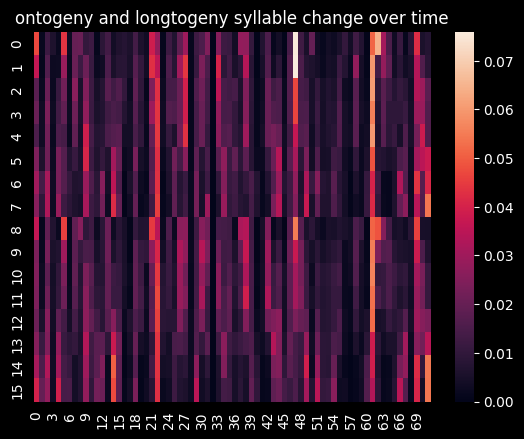

In [16]:
sns.heatmap(combined_plot)
plt.title('ontogeny and longtogeny syllable change over time')

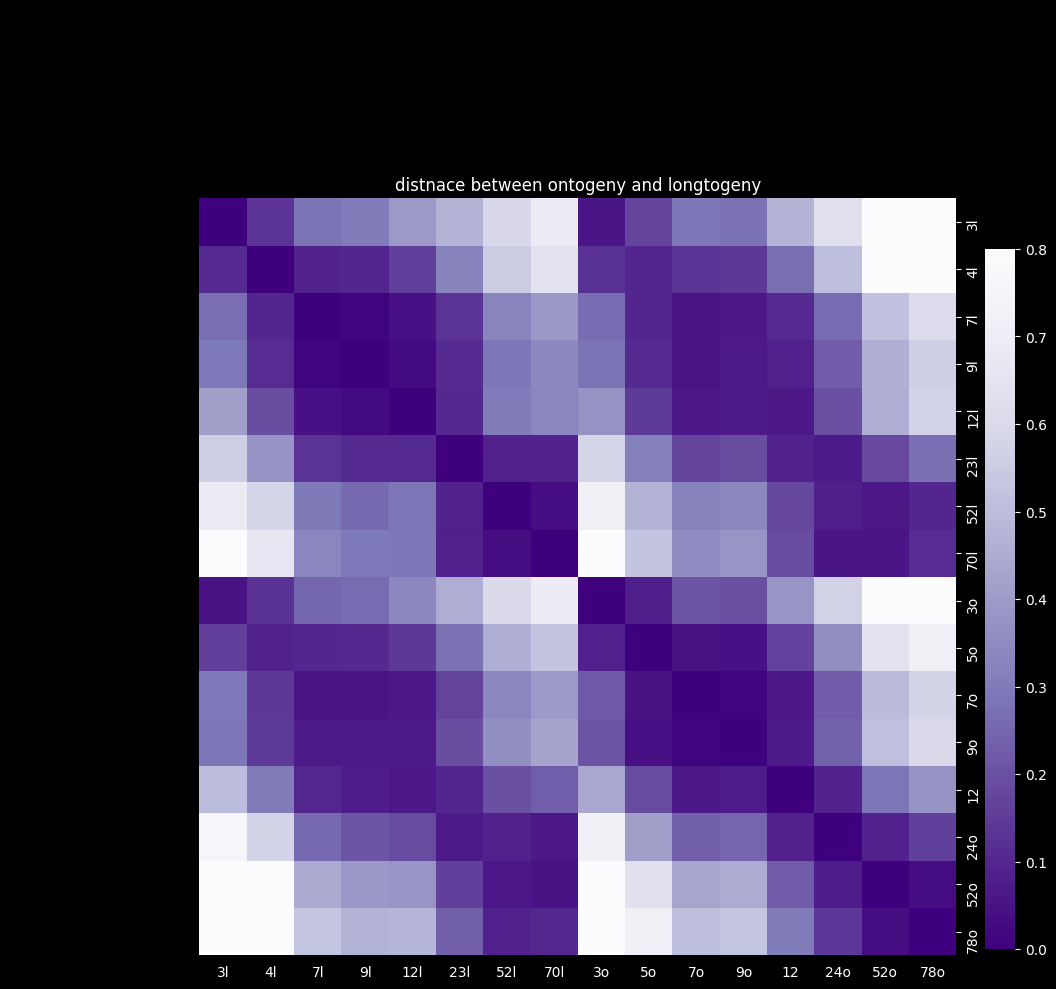

In [17]:
# match both
labels_ont = ['3o','5o','7o','9o','12','24o','52o','78o']
labels_long= ['3l','4l','7l','9l','12l','23l','52l','70l']

kld=KLD_analysis(combined_plot)
plot_KLD(kld,labels_long+labels_ont,0.8)

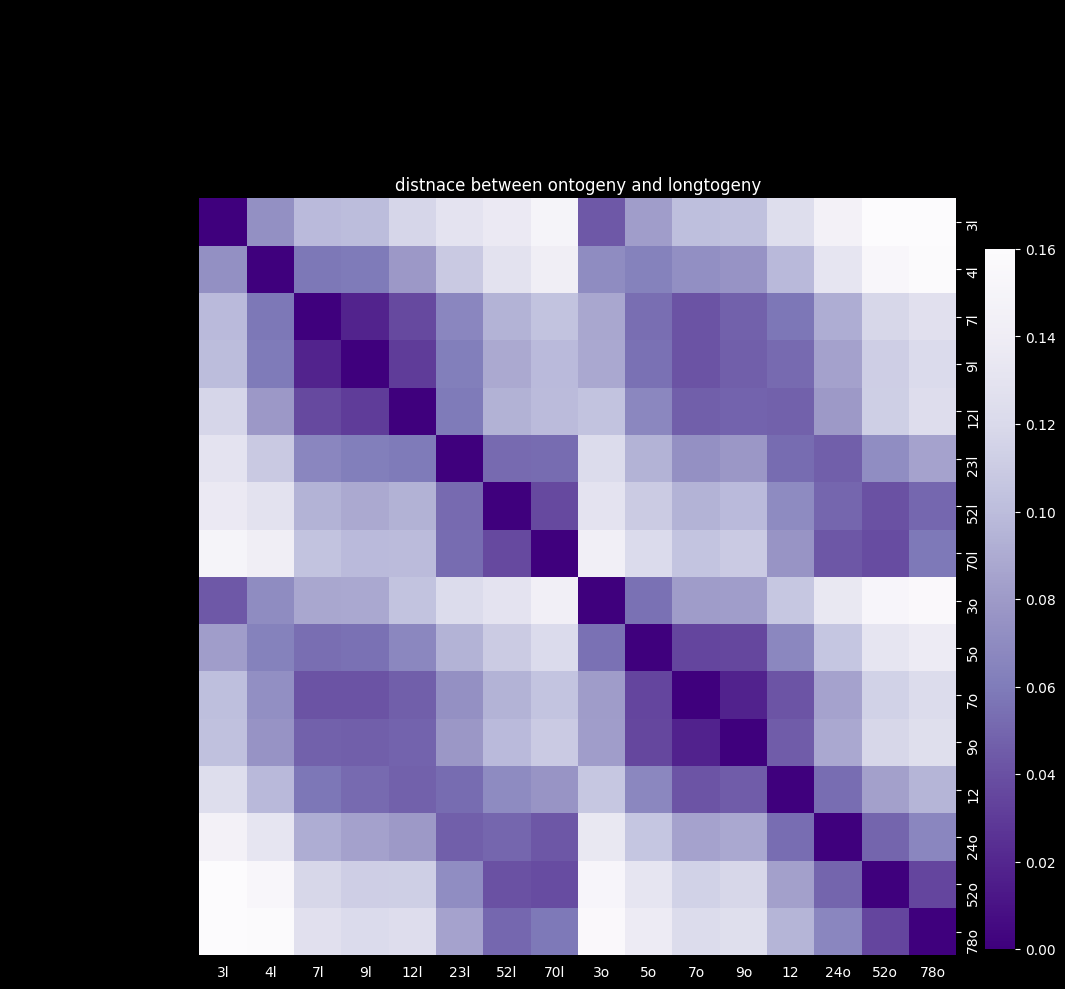

In [18]:
from sklearn.metrics import pairwise_distances
euc = pairwise_distances(combined_plot)
plot_KLD(euc,labels_long+labels_ont,0.16)

## fit linear regression for each syllable

In [19]:
combined=pd.concat([long_plot,ont_plot])
combined_plot=combined.dropna(axis=1)

In [20]:
# prepare data
long_temp = combined_plot[combined_plot.exp=='long'].drop('exp',axis=1).to_numpy()
long_temp = np.log(long_temp + 1e-6) # convert to linear
ont_temp = combined_plot[combined_plot.exp=='ont'].drop('exp',axis=1).to_numpy()
ont_temp = np.log(ont_temp + 1e-6) # convert to linear
x = ont_wks

In [21]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
x = np.array(range(len(x)))
x = sm.add_constant(x)

fr2=[]
fpvalue=[]
fslop=[]
fexp=[]
mr2=[]
mpvalue=[]
mslop=[]
mexp=[]

for i in range(np.shape(long_temp)[1]):
    y=long_temp[:,i]
    #fit linear regression model
    model = sm.OLS(y, x).fit()
    #view model summary
    mr2.append(model.rsquared)
    mpvalue.append(model.f_pvalue)
    mslop.append(model.params[1])
    #fexp.append('male')
    
for i in range(np.shape(ont_temp)[1]):
    y=ont_temp[:,i]
    #fit linear regression model
    model = sm.OLS(y, x).fit()
    #view model summary
    fr2.append(model.rsquared)
    fpvalue.append(model.f_pvalue)
    fslop.append(model.params[1])
    #fexp.append('female')

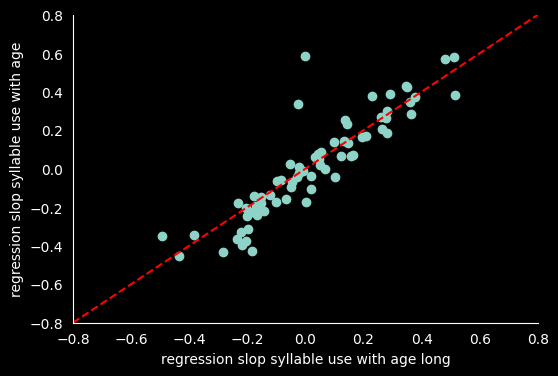

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
plt.scatter(x=mslop, y=fslop)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='--', c='r')
plt.ylim(-0.8, 0.8)
plt.xlim(-0.8, 0.8)
plt.xlabel('regression slop syllable use with age long')
plt.ylabel('regression slop syllable use with age')
#plt.title('linear change (slop) in syllables usage in different experiments')
sns.despine()

In [23]:
x = np.array(range(len(x)))
x = x.reshape(-1,1)
y=mdf_temp[:,0]

NameError: name 'mdf_temp' is not defined

In [ ]:
regression_model = LinearRegression()
  
# Fit the data(train the model)
regression_model.fit(x, y)
r2 = regression_model.score(x,y)
  
# printing values
print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('R2 score: ', r2)

#display regression coefficients and R-squared value of model
print(model.intercept_, model.coef_, model.score(X, y))

In [ ]:
#display regression coefficients and R-squared value of model
print(model.intercept_, model.coef_, model.score(X, y))

70.4828205704 [ 5.7945 -1.1576] 0.766742556527

In [ ]:
import statsmodels.api as sm

#define response variable
y = df['y']

#define predictor variables
x = df[['x1', 'x2']]

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

model.pvalues